In [73]:
import math
from collections import deque

class Value:

    def __init__(self, data, children=[], op='', label=''):
        if not label:
            raise Exception(f"Label missing for node with value {data}")
        self.data = data
        self.grad = 0.0
        self.children = children
        self.op = op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        if not self.label:
            raise Exception(f"Label missing for node with value {self.data}")
        common = f'data={self.data:.4f} | grad={self.grad:.4f}'
        return f"{self.label}|{common}"
        

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data + other.data, [self, other], '+', self.label + '+' + other.label)
        def _backward():
            self.grad += res.grad
            other.grad += res.grad
        res._backward = _backward
        return res

    def __rmul__(self, other):
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f'{str(other)}')
        res = Value(self.data * other.data, [self, other], '*', self.label + '*' + other.label)
        def _backward():
            self.grad += res.grad * other.data
            other.grad += res.grad * self.data
        res._backward = _backward
        return res
        

    def exp(self):
        val = math.exp(self.data * 1.0)
        res = Value(val, [self], 'exp', label=f'e**({self.label})')
        def _backward():
            self.grad += res.grad * val
        res._backward = _backward
        return res

        
    def tanh(self):
        exp = math.exp(2 * self.data * 1.0)
        val = (exp - 1) / (exp + 1)
        res = Value(val, [self], 'tanh', label=f'tanh({self.label})')
        def _backward():
            self.grad += res.grad * (1 - res.data * res.data)
        res._backward = _backward
        return res
            
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f'{str(other)}')
        res = Value(self.data ** other.data, [self, other], '**', label=f'{self.label} ** {other.label}')
        def backward():
            self.grad += res.grad * (other.data * (self.data ** (other.data - 1)))
        res._backward = backward
        return res

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * (other ** -1)


    def __sub__(self, other):
        return self + (-other)
        
    def __neg__(self):
        return self * -1
   

    def topo_sort(self, root):
        res = []
        node_to_num_edges = {}
        visited = set()
        def update_edges_count(n):
            for child in n.children:
                if child not in node_to_num_edges:
                    node_to_num_edges[child] = 0
                node_to_num_edges[child] += 1
            for child in n.children:
                if child not in visited:
                    visited.add(child)            
                    update_edges_count(child)
        node_to_num_edges[root] = 0
        visited.add(root)
        update_edges_count(root)
            
        q = deque()
        visited = set()
        for node in node_to_num_edges:
            if node_to_num_edges[node] == 0:
                q.append(node)
                visited.add(node)
    
        while len(q) != 0:
            node = q.popleft()
            res.append(node)
            for child in node.children:
                node_to_num_edges[child] -= 1
            for node in node_to_num_edges:
                if node not in visited and node_to_num_edges[node] == 0:
                    q.append(node)
                    visited.add(node)
        return res
    
    def backward(self):
        self.grad = 1
        ordered_nodes = self.topo_sort(self)
        for node in ordered_nodes:
            node._backward()

In [74]:
import random
class Neuron:

    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1, 1), label=f'w{str(index)}') for index in range(num_inputs)]
        self.b = Value(random.uniform(-1, 1), label='b')

    def __call__(self, x):
        # w*x + b
        total = self.b
        for index, (a, b) in enumerate(zip(self.w, x)):
            b_val = Value(b, label=f'x{index}')
            product = (b_val * a); 
            addition = total + product;
            total = addition
        tanh = total.tanh()
        return tanh

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, num_inputs, num_outputs):
            self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

    def __call__(self, x):
        res = [n(x) for n in self.neurons]
        return res[0] if len(res) == 1 else res

    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params


class MLP:

    def __init__(self, num_inputs, layer_sizes):
        sz = [num_inputs] + layer_sizes
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(sz) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

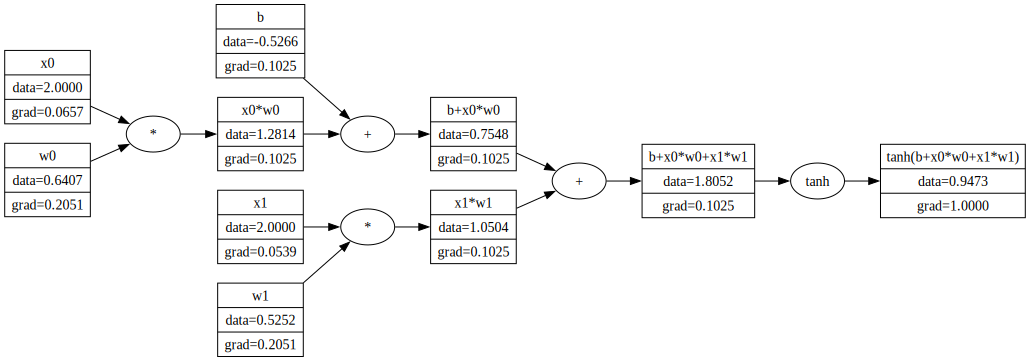

In [75]:
from graphviz import Digraph
from collections import deque


class GraphDrawer:

    def __init__(self):
        self.node_to_id = {}
        self.dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        
    def get_graph(self, root):
        q = deque()
        visited = set()
        q.append(root)
        visited.add(root)
        while len(q) != 0:
            cur = q.popleft()
            self.dot.node(name=self.get_id(cur), label=str(cur), shape='record')
            cur_id_with_op = self.get_id(cur) + cur.op
            if cur.op:
                self.dot.edge(cur_id_with_op, self.get_id(cur))
                self.dot.node(name=cur_id_with_op, label=cur.op)
                
            for child in cur.children:
                self.dot.edge(self.get_id(child), cur_id_with_op)
                if child not in visited:
                    q.append(child)
                    visited.add(child)
                
    def get_id(self, node):
        if node not in self.node_to_id:
            self.node_to_id[node] = len(self.node_to_id)
        return str(self.node_to_id[node])
    
    def draw(self, node):
        g = self.get_graph(node)
        return self.dot

# create a neuron and run a backward pass
n = Neuron(2)
o = n([2, 2])
o.backward()

# draw the graph for that neuron
d = GraphDrawer()
d.draw(o)

In [76]:
import numpy as np
np.random.seed(1337)
random.seed(1337)

# make up a dataset
from sklearn.datasets import make_moons
NUM_SAMPLES = 100
X, Y = make_moons(n_samples=NUM_SAMPLES, noise=0.1)

Y = Y*2 - 1 # make Y -1 or 1




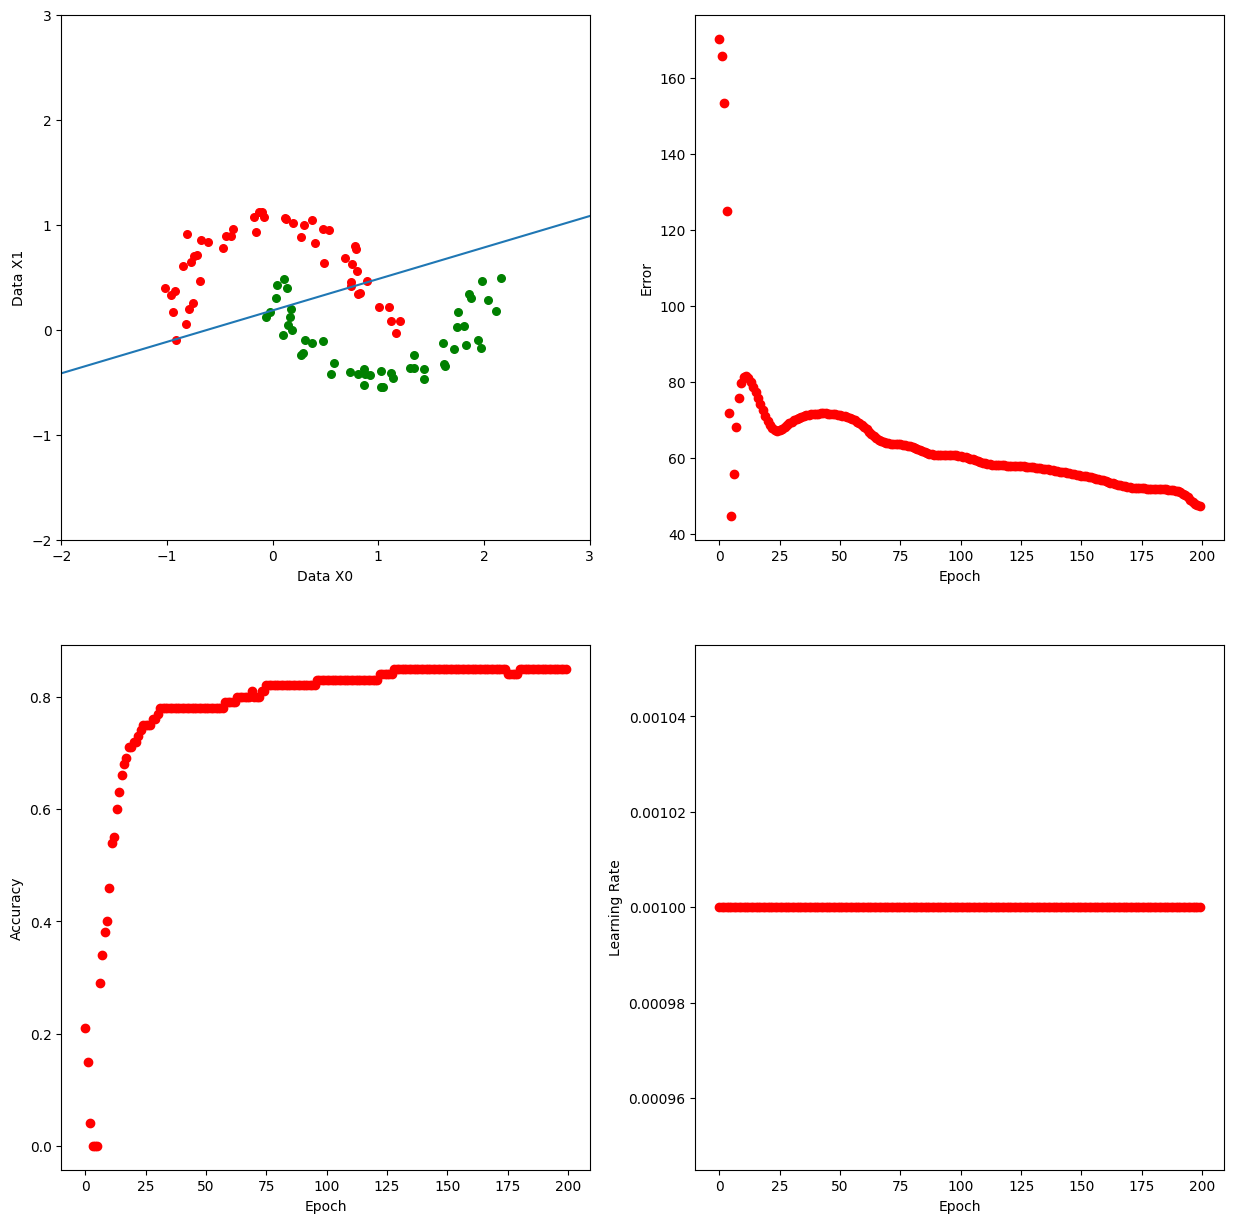

In [92]:
from IPython.display import display, clear_output
from matplotlib import pyplot as plt 
# %matplotlib inline

def train(X, Y, n, plotter):
    EPOCHS = 200
    DELTA = 0.001
    
    for k in range(EPOCHS):
        # run a foward pass
        error = Value(0, label='error')
        correct_predictions = 0.0
        incorrect_predictions = 0.0
        for index, (x, y) in enumerate(zip(X, Y)):
            neuron_value = n([x[0], x[1]])
            y_value = Value(y, label='y')
            diff = neuron_value - y_value; 
            prod = diff ** 2
            error = prod + error
            if abs(diff.data) < 0.1:
                correct_predictions += 1
            else:
                incorrect_predictions += 1
        
        # run a backward pass
        error.backward()
    
        # adjust the weights
        for p in n.parameters():
            # direction = 1 if p.grad >= 0 else -1
            p.data = p.data - DELTA * p.grad

            
        # get the x-intercept and y-intercept to show the decision boundary
        [w0, w1, b] = n.parameters()
        x_intercept = -b.data / w0.data
        y_intercept = -b.data / w1.data
        # visualize the decision boundary
        plotter.show_decision_boundary_and_stats(n, error, k, correct_predictions, incorrect_predictions, DELTA, x_intercept, y_intercept)



class Plotter:

    def __init__(self, X, Y):
        # Create a figure for visualization the data
        self.fig, ax = plt.subplots(2, 2, figsize=(15, 15))

        # figure to show the decision boundary
        self.decision_boundary_plot = ax[0][0]
        self.decision_boundary_plot.set_xlim([-2, 3])
        self.decision_boundary_plot.set_ylim([-2, 3])
        self.decision_boundary_plot.set_xlabel("Data X0")
        self.decision_boundary_plot.set_ylabel("Data X1")

        # figure to show the error plot
        self.error_plot = ax[0][1]
        self.error_plot.set_xlabel("Epoch")
        self.error_plot.set_ylabel("Error")

        # figure to show accuracy
        self.accuracy_plot = ax[1][0]
        self.accuracy_plot.set_xlabel("Epoch")
        self.accuracy_plot.set_ylabel("Accuracy")

        # figure to show learning rate
        self.learning_rate_plot = ax[1][1]
        self.learning_rate_plot.set_xlabel("Epoch")
        self.learning_rate_plot.set_ylabel("Learning Rate")
        
        # Show the scatter plot for the input data
        for (x, y) in zip(X,Y):
            color = 'red' if y == -1 else 'green'
            self.decision_boundary_plot.scatter(x[0], x[1], c=color, s=30)
        self.decision_boundary_line = self.decision_boundary_plot.axline([0, 0], [0, 0])

        
        
    def show_decision_boundary_and_stats(self, predictor, error, k, correct_predictions, incorrect_predictions, learning_rate, x_intercept, y_intercept):
        # update the decision boundary
        self.decision_boundary_line.set_xy1(x_intercept, 0)
        self.decision_boundary_line.set_xy2(0, y_intercept)
                     
        # update the error
        self.error_plot.plot(k, error.data, 'ro')

        # update the accuracy
        accuracy = (correct_predictions) / (correct_predictions + incorrect_predictions)
        self.accuracy_plot.plot(k, accuracy, 'ro')

        # update the learning rate
        self.learning_rate_plot.plot(k, learning_rate, 'ro')
    
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        plt.close()
    

# create a plotter to visualize the training process
plotter = Plotter(X, Y)

# create a neuron
n = Neuron(2)

# Train the neuron with these hyper-parameters
train(X, Y, n, plotter)

# Close plotter when done
plotter.close()  